# Setup

## Load packages

In [1]:
install.packages("caret")

library(tidyverse)  # Data wrangling packages.

my_bucket <- Sys.getenv('WORKSPACE_BUCKET')

library(glmnet)
library(dplyr)
library(pROC)
library(broom)
library(caret)

Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: lattice


Attaching package: ‘caret’


The following obj

## Load and merge data

In [64]:
name_of_file_in_bucket <- 'Demographic_and_ancestry_covariates.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
demo  <- read_csv(name_of_file_in_bucket) |> 
    select(-c(income, education)) |> 
    rename(age = age_at_last_event)

name_of_file_in_bucket <- 'SES_data.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
ses_data  <- read_csv(name_of_file_in_bucket)

all_data <- merge(
  demo,
  ses_data,
  by = "person_id"
)

name_of_file_in_bucket <- 'Case_Control_df.csv'
system(paste0("gsutil cp gs://fc-secure-672eeb92-4859-4ed9-9f59-d4349f3534a0/notebooks/Case_Control_df.csv ."), intern=T)
case_control  <- read_csv(name_of_file_in_bucket)

merged_data<-merge(all_data, case_control, on="person_id", how="inner")

character(0)

Rows: 135611 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (9): SexGender, ancestry_pred, education, where_born, military, health...
dbl  (29): person_id, race_unknown, age_today, PC_1, PC_2, PC_3, PC_4, PC_5,...
lgl   (8): AIAN, Asian, Black, Mid, Multiple, PI, White, His
dttm  (1): basics_survey_datetime
date  (3): date_of_birth, min_date, max_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

Rows: 214915 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (11): person_id, income, education, per_poverty_threshold, fraction_assi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

Rows: 265954 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): person_id, Asthma, Afib, BreastC, CKD, CHD, HyperC, ProstateC, t2d...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Format data

In [3]:
merged_data <- merged_data %>%
  mutate(
    SexGenderCis_male = ifelse(SexGender == "Cis_male", 1, 0),
    SexGenderCis_female = ifelse(SexGender == "Cis_female", 1, 0),
    SexGenderSGM = ifelse(SexGender == "SGM", 1, 0)
  )

merged_data$age2 <- merged_data$age^2

domains<-c('per_poverty_threshold', 'education', 
           'fraction_assisted_income', 'fraction_high_school_edu', 'median_income', 
           'fraction_no_health_insurance', 'fraction_poverty', 'fraction_vacant_housing', 'deprivation_index')       


merged_data$per_poverty_threshold <- 1 - merged_data$per_poverty_threshold

#Hard code to match disease names in case_control dataframe 
diseases<-c("Asthma", "Afib", "BreastC", "CKD", "CHD", "ProstateC", "t2d", "t1d")


# Elastic Net Function

In [4]:
run_elastic_net <- function(diseases, selection_terms, merged_data) {
  
  ####---------------------------------------------------------------
  #### 1. Set up output structure
  ####---------------------------------------------------------------
  
  # Columns to report per disease
  columns <- c("mean_train_score", "sd_train_score", 
               "mean_test_score", "sd_test_score", 
               "mean_AUC", "sd_AUC",
               "n_predictors", "Predictors",
               "mean_coef", "sd_coef", 
               "coef_nonzero_count")
  
  # Empty results table, one row per disease
  elastic_net_results <- setNames(
    data.frame(matrix(ncol = length(columns), nrow = length(diseases))),
    columns
  )
  rownames(elastic_net_results) <- diseases
  
  # Store full predictions for all individuals for each disease
  all_scores <- list()
  
  
  ####---------------------------------------------------------------
  #### 2. Loop through each disease and fit Elastic Net
  ####---------------------------------------------------------------
  
  for (disease in diseases) {
    
    # Subset data to disease + predictors, drop missing
    df <- merged_data %>%
      select(all_of(c("person_id", disease, selection_terms))) %>%
      drop_na()
    
    # Covariate matrix X and outcome y
    X <- as.matrix(df %>% select(all_of(selection_terms)))
    y <- as.numeric(df[[disease]])
    
    # Penalty factors (all predictors penalized equally)
    penalty_factors <- rep(1, ncol(X))
    
    # Cross-validation batches
    n_splits <- 5
    train_scores <- c()
    test_scores  <- c()
    aucs         <- c()
    coef_map     <- list()   # to store coefficients per CV split
    
    set.seed(123)
    
    
    ####---------------------------------------------------------------
    #### 3. 5-fold cross-validation loop
    ####---------------------------------------------------------------
    
    for (i in 1:n_splits) {
      
      # Split 70/30 train/test
      train_index <- createDataPartition(y, p = 0.7, list = FALSE)
      
      X_train <- X[train_index, , drop = FALSE]
      X_test  <- X[-train_index, , drop = FALSE]
      y_train <- y[train_index]
      y_test  <- y[-train_index]
      
      # ---- Min–max scaling using TRAIN ONLY ----
      scale_min <- apply(X_train, 2, min, na.rm = TRUE)
      scale_max <- apply(X_train, 2, max, na.rm = TRUE)

      # prevent division by zero: if max == min, set range to 1
      scale_range <- scale_max - scale_min
      scale_range[scale_range == 0] <- 1

      # Scale training set
      X_train <- sweep(X_train, 2, scale_min, FUN = "-")
      X_train <- sweep(X_train, 2, scale_range, FUN = "/")

      # Scale test set using *training* mins/maxes
      X_test <- sweep(X_test, 2, scale_min, FUN = "-")
      X_test <- sweep(X_test, 2, scale_range, FUN = "/")
  
           
      # CV elastic net (alpha = 0.5)
      cv_model <- cv.glmnet(
        X_train, y_train,
        alpha = 0.5,
        family = "binomial",
        penalty.factor = penalty_factors
      )
      
      # Best penalty value
      best_lambda <- cv_model$lambda.min
      
      # Final fitted model
      final_model <- glmnet(
        X_train, y_train,
        alpha = 0.5, 
        lambda = best_lambda,
        family = "binomial",
        penalty.factor = penalty_factors
      )
      
      # Evaluate on training data
      model_eval <- assess.glmnet(cv_model, newx = X_train, newy = y_train)
      
      # Store coefficients (including intercept)
      coef_matrix <- coef(final_model)
      coef_vec <- as.vector(coef_matrix)
      names(coef_vec) <- rownames(coef_matrix)
      coef_map[[i]] <- coef_vec
      
      # Test performance via correlation of linear predictor
      predictions <- predict(final_model, newx = X_test, type = "link")
      test_scores <- c(test_scores, cor(predictions, y_test, use = "complete.obs"))
      
      # Training score from CV
      train_scores <- c(train_scores, cv_model$cvm[cv_model$lambda == best_lambda])
      
      # AUC
      aucs <- c(aucs, as.numeric(model_eval$auc))
    }
    
    
    ####---------------------------------------------------------------
    #### 4. Summarize coefficients across CV splits
    ####---------------------------------------------------------------
    
    # Convert list of coefficient vectors → long data frame
    coef_df <- bind_rows(lapply(coef_map, function(x) as.data.frame(t(x))))
    coef_df[is.na(coef_df)] <- 0
    
    coef_means <- colMeans(coef_df)
    coef_sds   <- apply(coef_df, 2, sd)
    coef_nonzero_counts <- colSums(coef_df != 0)
    
    # Exclude intercept when counting predictors
    n_predictors <- sum(coef_nonzero_counts[-1] != 0)
    
    
    ####---------------------------------------------------------------
    #### 5. Compute predictions for ALL individuals
    ####---------------------------------------------------------------
    
    df_all <- merged_data %>%
      select(all_of(c("person_id", disease, selection_terms))) %>%
      drop_na()
    
    X_mat <- as.matrix(df_all %>% select(all_of(selection_terms)))
    
    beta <- rep(0, ncol(X_mat))
    names(beta) <- colnames(X_mat)
    
    beta[names(coef_means)[-1]] <- coef_means[-1]  # predictor coefficients
    intercept <- coef_means["(Intercept)"]
    
    Xb <- X_mat %*% beta + intercept
    
    preds_all <- data.frame(
      person_id  = df_all$person_id,
      prediction = as.vector(Xb)
    )
    
    all_scores[[disease]] <- preds_all
    
    
    ####---------------------------------------------------------------
    #### 6. Store results in the output table
    ####---------------------------------------------------------------
    
    elastic_net_results[disease, "mean_train_score"] <- mean(train_scores)
    elastic_net_results[disease, "sd_train_score"]   <- sd(train_scores)
    elastic_net_results[disease, "mean_test_score"]  <- mean(test_scores)
    elastic_net_results[disease, "sd_test_score"]    <- sd(test_scores)
    
    elastic_net_results[disease, "mean_AUC"] <- mean(aucs)
    elastic_net_results[disease, "sd_AUC"]   <- sd(aucs)
    
    # Keep only non-zero predictors
    nonzero_predictors <- names(coef_means)[-1][coef_means[-1] != 0]
    nonzero_means      <- coef_means[nonzero_predictors]
    nonzero_sds        <- coef_sds[nonzero_predictors]
    nonzero_counts     <- coef_nonzero_counts[nonzero_predictors]

    elastic_net_results[disease, "n_predictors"]         <- length(nonzero_predictors)
    elastic_net_results[disease, "Predictors"]           <- paste(nonzero_predictors, collapse = ",")
    elastic_net_results[disease, "mean_coef"]            <- paste(round(nonzero_means, 6), collapse = ",")
    elastic_net_results[disease, "sd_coef"]              <- paste(round(nonzero_sds, 6), collapse = ",")
    elastic_net_results[disease, "coef_nonzero_count"]   <- paste(nonzero_counts, collapse = ",")
                                    
    message(paste("Completed Elastic Net for:", disease))
  }
  
  # Add disease names as a column
  elastic_net_results$Disease <- rownames(elastic_net_results)
  
  return(list(
    model_summary     = elastic_net_results,
    individual_scores = all_scores
  ))
}




# Run ENs

In [5]:
results_all <- run_elastic_net(diseases, domains, merged_data)

write_excel_csv(results_all[[1]], 'elastic_net_results.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./elastic_net_results.csv ", my_bucket, "/data/"), intern=T)

Completed Elastic Net for: Asthma

Completed Elastic Net for: Afib

Completed Elastic Net for: BreastC

Completed Elastic Net for: CKD

Completed Elastic Net for: CHD

Completed Elastic Net for: ProstateC

Completed Elastic Net for: t2d

Completed Elastic Net for: t1d



character(0)

In [6]:
selection_terms_no_income<-c('education', 
           'fraction_assisted_income', 'fraction_high_school_edu', 'median_income', 
           'fraction_no_health_insurance', 'fraction_poverty', 'fraction_vacant_housing', 'deprivation_index')       


results_no_income <- run_elastic_net(diseases, selection_terms_no_income, merged_data)

write_excel_csv(results_no_income[[1]], 'elastic_net_results_no_income.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./elastic_net_results_no_income.csv ", my_bucket, "/data/"), intern=T)


Completed Elastic Net for: Asthma

Completed Elastic Net for: Afib

Completed Elastic Net for: BreastC

Completed Elastic Net for: CKD

Completed Elastic Net for: CHD

Completed Elastic Net for: ProstateC

Completed Elastic Net for: t2d

Completed Elastic Net for: t1d



character(0)

# Make Weights File

In [26]:
df_long <- results_all[[1]] %>%
  mutate(
    Predictors = str_split(Predictors, ",\\s*"),
    mean_coef  = str_split(mean_coef, ",\\s*")
  ) %>%
  # Unnest the lists into rows
  unnest(c(Predictors, mean_coef)) %>%
  # Convert coef to numeric
  mutate(mean_coef = as.numeric(mean_coef)) |>
  select(Disease, Predictors, mean_coef) |>
  rename("Predictor" = "Predictors")

# Pivot weights to wide (disease = column, predictors = rows)
weights_wide <- df_long %>%
  pivot_wider(names_from = Disease, values_from = mean_coef)

write_excel_csv(weights_wide, 'PsRS_weights_file.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./PsRS_weights_file.csv ", my_bucket, "/data/"), intern=T)


character(0)

In [27]:
df_long <- results_no_income[[1]] %>%
  mutate(
    Predictors = str_split(Predictors, ",\\s*"),
    mean_coef  = str_split(mean_coef, ",\\s*")
  ) %>%
  # Unnest the lists into rows
  unnest(c(Predictors, mean_coef)) %>%
  # Convert coef to numeric
  mutate(mean_coef = as.numeric(mean_coef)) |>
  select(Disease, Predictors, mean_coef) |>
  rename("Predictor" = "Predictors")

# Pivot weights to wide (disease = column, predictors = rows)
weights_wide <- df_long %>%
  pivot_wider(names_from = Disease, values_from = mean_coef)


write_excel_csv(weights_wide, 'PsRS_weights_file_no_income.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./PsRS_weights_file_no_income.csv ", my_bucket, "/data/"), intern=T)


character(0)

# Calculate PsRS using AoU weights

In [65]:
name_of_file_in_bucket <- 'PsRS_weights_file_no_income.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
PsRS_weights_no_income <- read_csv(name_of_file_in_bucket)

name_of_file_in_bucket <- 'PsRS_weights_file.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
PsRS_weights <- read_csv(name_of_file_in_bucket)

all_data <- all_data %>%
  mutate(across(all_of(domains), ~ (.-min(., na.rm = TRUE)) / 
                               (max(., na.rm = TRUE) - min(., na.rm = TRUE))))

all_data <- all_data |> select("person_id", domains)

character(0)

Rows: 8 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Predictor
dbl (8): Asthma, Afib, BreastC, CKD, CHD, ProstateC, t2d, t1d

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

Rows: 9 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Predictor
dbl (8): Asthma, Afib, BreastC, CKD, CHD, ProstateC, t2d, t1d

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## PsRS with income

In [66]:
# ---- 1. Pivot all_data to long ----
long_data <- all_data %>%
  select(person_id, all_of(domains)) %>%
  pivot_longer(
    cols = all_of(domains),
    names_to = "Predictor",
    values_to = "value"
  )

# ---- 2. Pivot weights to long ----
weights_long <- PsRS_weights %>%
  pivot_longer(
    cols = all_of(diseases),
    names_to = "disease",
    values_to = "coef"
  )

# ---- 3. Join and compute partial score ----
joined <- long_data %>%
  left_join(weights_long, by = "Predictor", relationship= "many-to-many") %>%
  mutate(score_part = value * coef)

# ---- 4. Summarize into full scores per disease per person ----
score_wide <- joined %>%
  group_by(person_id, disease) %>%
  summarize(score = sum(score_part, na.rm = TRUE), .groups = "drop") %>%
  pivot_wider(
    names_from = disease,
    values_from = score,
    values_fill = 0
  ) %>%
  rename_with(~ paste0(., "_PsRS"), -person_id)

write_excel_csv(score_wide, 'individual_PsRS.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./individual_PsRS.csv ", my_bucket, "/data/"), intern=T)

character(0)

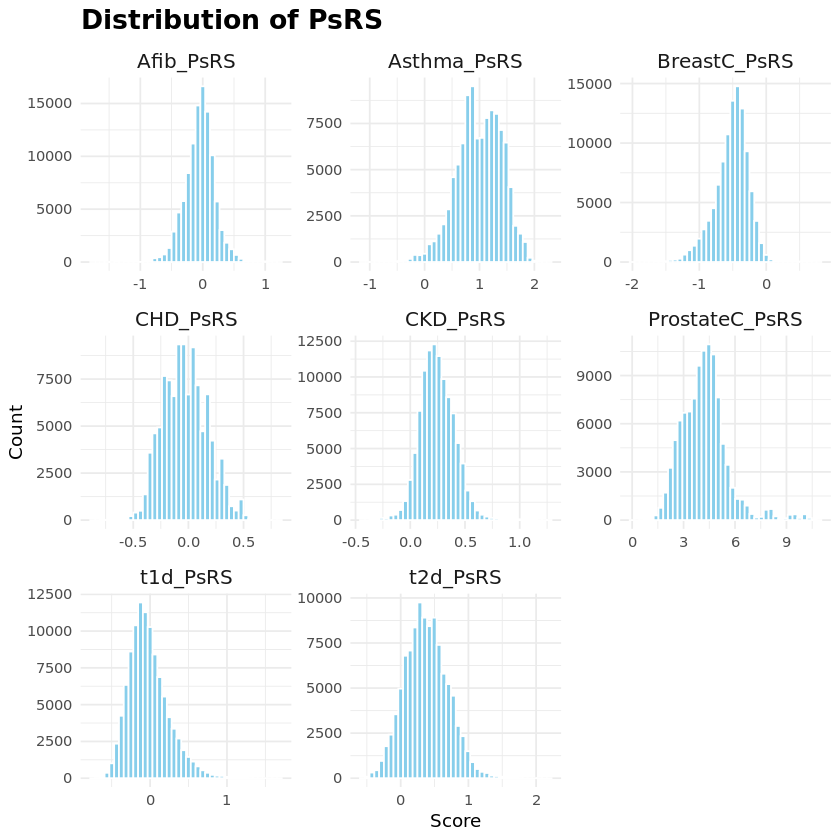

In [67]:
# Pivot to long format
scores_long <- score_wide %>%
  pivot_longer(
    cols = ends_with("_PsRS"),
    names_to = "disease",
    values_to = "score"
  )

# Plot facet-wrapped histograms
ggplot(scores_long, aes(x = score)) +
  geom_histogram(bins = 40, fill = "skyblue", color = "white") +
  facet_wrap(~ disease, scales = "free") +
  theme_minimal() +
  labs(
    title = "Distribution of PsRS",
    x = "Score",
    y = "Count"
  ) +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    strip.text = element_text(size = 12)
  )


## PsRS without income

character(0)

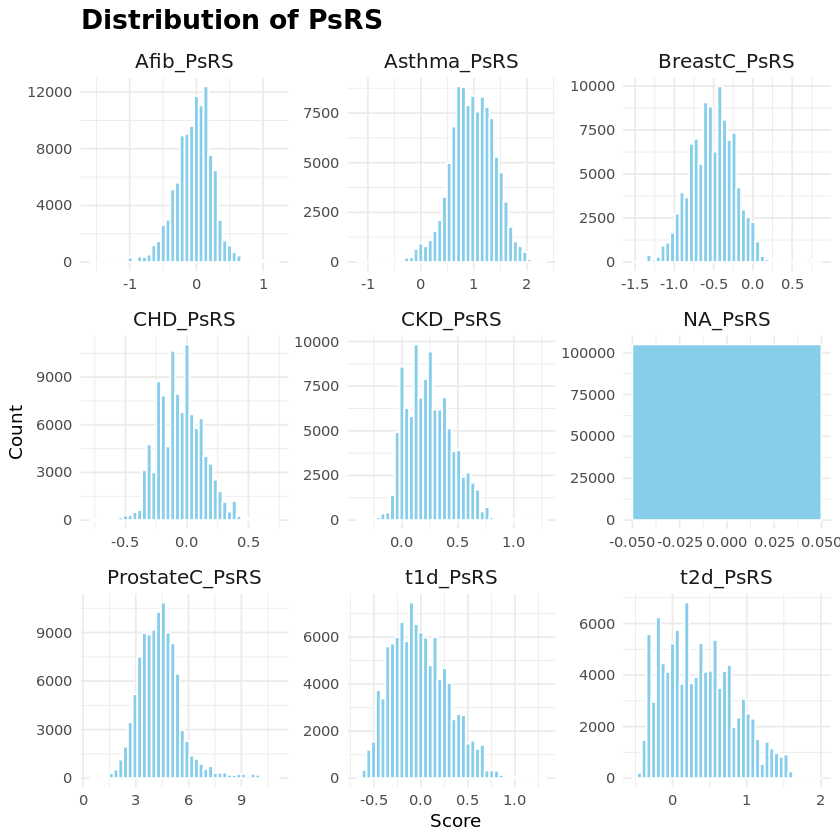

In [68]:
# ---- 1. Pivot all_data to long ----
long_data <- all_data %>%
  select(person_id, all_of(domains)) %>%
  pivot_longer(
    cols = all_of(domains),
    names_to = "Predictor",
    values_to = "value"
  )

# ---- 2. Pivot weights to long ----
weights_long <- PsRS_weights_no_income %>%
  pivot_longer(
    cols = all_of(diseases),
    names_to = "disease",
    values_to = "coef"
  )

# ---- 3. Join and compute partial score ----
joined <- long_data %>%
  left_join(weights_long, by = "Predictor", relationship= "many-to-many") %>%
  mutate(score_part = value * coef)

# ---- 4. Summarize into full scores per disease per person ----
score_wide <- joined %>%
  group_by(person_id, disease) %>%
  summarize(score = sum(score_part, na.rm = TRUE), .groups = "drop") %>%
  pivot_wider(
    names_from = disease,
    values_from = score,
    values_fill = 0
  ) %>%
  rename_with(~ paste0(., "_PsRS"), -person_id)

write_excel_csv(score_wide, 'individual_PsRS_no_income.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./individual_PsRS_no_income.csv ", my_bucket, "/data/"), intern=T)

# Pivot to long format
scores_long <- score_wide %>%
  pivot_longer(
    cols = ends_with("_PsRS"),
    names_to = "disease",
    values_to = "score"
  )

# Plot facet-wrapped histograms
ggplot(scores_long, aes(x = score)) +
  geom_histogram(bins = 40, fill = "skyblue", color = "white") +
  facet_wrap(~ disease, scales = "free") +
  theme_minimal() +
  labs(
    title = "Distribution of PsRS",
    x = "Score",
    y = "Count"
  ) +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    strip.text = element_text(size = 12)
  )
